In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
from matplotlib.lines import Line2D
import matplotlib.image as img
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from ipywidgets import interact
import ipywidgets as widgets
from tqdm import tqdm
from scipy import integrate
from scipy import sparse
from pyDOE import lhs
from scipy.interpolate import griddata
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
torch.set_default_tensor_type(torch.DoubleTensor)
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
h = 1e-2
m = 1
x0_phase = -5

# get initial condition values
def psi_0(x, x0=0.0, sigma=np.sqrt(0.1), x0_phase=-5):
    A = 1.0 / (sigma * np.sqrt(2*np.pi)) 
    return np.sqrt(A) * np.exp(-(x-x0)**2 / (4.0 * (sigma**2))) * np.exp(1j * x0_phase * x)

# potential for the PINN loss
def potential_V(x):
    return 0.5*(x - 0.1)**2

In [4]:
class NN(nn.Module):
    def __init__(self, input_dim, hid_dim, output_dim):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hid_dim) 
        self.relu1 = nn.Tanh()
        self.fc2 = nn.Linear(hid_dim, hid_dim) 
        self.relu2 = nn.Tanh()
        self.fc3 = nn.Linear(hid_dim, output_dim) 

    def forward(self, x):
#         out = torch.hstack((x, t))
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        return out

### Prepare data

Assume we have $x \in [-2, 2]$ and $t \in [0, 1]$. 

In [5]:
# Doman bounds
lb = np.array([-2.0, 0.0])
ub = np.array([2.0, 1])

# number of IC points and BC points
N0 = 3000
N_b = 300
# number of collocation points
# N_f = 100000
N_f = 80000

delta_x = np.sqrt(1/200000)
delta_t = 0.001
# data = scipy.io.loadmat('NLS.mat')
x = np.arange(lb[0], ub[0], delta_x).astype(float)[:,None]
t = np.linspace(0, 1, 1000+1).astype(float)[:,None]
#t = np.arange(lb[1], ub[1], delta_t).astype(float)[:,None]
print(x.shape, t.shape)

X, T = np.meshgrid(x, t)
X_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
print(X_test.shape)

(1789, 1) (1001, 1)
(1790789, 2)


In [6]:
# getting IC points for training 
# x_init_grid = np.arange(lb[0], ub[0], delta_x).astype(float)
x_init_grid = np.arange(lb[0], ub[0], np.sqrt(1/600000)).astype(float)
sol_0 = psi_0(x_init_grid)
u_sol_0 = np.real(sol_0)
v_sol_0 = np.imag(sol_0)

idx_x = np.random.choice(u_sol_0.shape[0], N0, replace=False)
x0 = x_init_grid[idx_x, None] # need for training
ic_val = np.hstack((x0, np.zeros_like(x0)))
u0 = u_sol_0[idx_x, None]
v0 = v_sol_0[idx_x, None]
ic_sol = np.hstack((u0, v0)) # need for training


# getting BC points 
idx_t = np.random.choice(t.shape[0], N_b, replace=False)
tb = t[idx_t, :] # need for training
b_val_l = np.hstack((np.ones_like(tb)[:len(tb)//2]* lb[0], tb[:len(tb)//2]))
b_val_r = np.hstack((np.ones_like(tb)[len(tb)//2:]* ub[0], tb[len(tb)//2:]))
b_val = np.concatenate((b_val_l, b_val_l), axis=0) # need for training

# getting collocation points
X_f = lb + (ub - lb) * lhs(2, N_f)

In [7]:
def get_solution_regr(lb, ub, delta_X, delta_T):
    x = np.arange(lb[0], ub[0], delta_X).astype(float) #np.arange(lb[0], ub[0], delta_X).astype(float)
    t = np.arange(lb[1], ub[1], delta_T).astype(float)# np.arange(lb[1], ub[1], delta_T).astype(float)
#     print('x and t discretization', x.shape, t.shape)
    X, T = np.meshgrid(x, t)

    X = np.expand_dims(X.flatten(), axis=-1)
    T = np.expand_dims(T.flatten(), axis=-1)
    hbar = h
    
    # Laplace Operator (Finite Difference)
    D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / delta_X**2
    def psi_t(t, psi):
        return -1j * (-0.5 * h  / m * D2.dot(psi) + potential_V(x) / hbar * psi)

    # Solve the Initial Value Problem
    psi_val = integrate.solve_ivp(psi_t, t_span = [lb[1], ub[1]], 
                                  y0 = psi_0(x), t_eval = t, method="RK23")
    psi_val = psi_val.y.T
    print('sol shape', psi_val.shape)
    u = np.real(psi_val.reshape(-1, 1))
    v = np.imag(psi_val.reshape(-1, 1))

    train_input = np.hstack((X, T))
    train_output = np.hstack((u, v))

    return train_input, train_output

In [8]:
train_x, train_y = get_solution_regr(lb, ub, np.sqrt(1/10000), delta_t)
print(train_x.shape)
N_regr = 50000
idx = np.random.choice(train_x.shape[0], N_regr, replace=False)
train_x = train_x[idx]
train_y = train_y[idx]

sol shape (1000, 400)
(400000, 2)


In [9]:
X_f = torch.tensor(X_f).requires_grad_(True)
ic_val = torch.tensor(ic_val)#.requires_grad_(False)
ic_sol = torch.tensor(ic_sol)#.requires_grad_(False)
b_val = torch.tensor(b_val)#.requires_grad_(False)

# train_x = torch.tensor(train_x)
# train_y = torch.tensor(train_y)

In [10]:
X_f.shape, b_val.shape, ic_val.shape

(torch.Size([80000, 2]), torch.Size([300, 2]), torch.Size([3000, 2]))

We have the equation
$$i h \Psi_t + \frac{h^2}{2m} \Psi_{xx} - V(x) \Psi = 0. $$
​
Let $\Psi = u + i v,$ then we have 
$$i h (u_t + i v_t) + \frac{h^2}{2m} (u_{xx} + i v_{xx}) - V(x) (u + i v) = 0, $$
$$ih u_t - h v_t + \frac{h^2}{2m} u_{xx} + i \frac{h^2}{2m} v_{xx} - V(x)u - i V(x) v = 0$$
$$\big(- h  v_t + \frac{h^2}{2m} u_{xx} - V(x)u\big) + i \big(h u_t + \frac{h^2}{2m} v_{xx} -  V(x)v\big) = 0. $$
It's $L_f $ loss.

In [11]:
def train_pinn(model, n_epochs, f_colloc, b_colloc, ic_colloc, ic, 
               lambda_data=0, lambda_pde=1, sample_idx=False):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_list = np.zeros(n_epochs)
    loss_physics_list = np.zeros(n_epochs)
    loss_b_list = np.zeros(n_epochs)
    loss_ic_list = np.zeros(n_epochs)
    loss_regr_list = np.zeros(n_epochs)

    with tqdm(range(n_epochs), unit="epoch") as tepoch:
        for i in tepoch:
            optimizer.zero_grad()
            N_subs_regr = 10000
            N_subs_colloc = 10000
            if lambda_data > 0:
                if sample_idx:
                    idx_subsample = np.random.choice(train_x.shape[0], N_subs_regr, replace=False)
                    train_x_sub = train_x[idx_subsample]
                    train_y_sub = train_y[idx_subsample]
                    y_pred = model(train_x_sub.to(device))
                    loss1 = torch.mean((y_pred - train_y_sub.to(device))**2)
                else:
                    y_pred = model(train_x.to(device))
                    loss1 = torch.mean((y_pred-train_y.to(device))**2)
            else:
                loss1 = torch.tensor(0) 
                
            # calculate loss on colloc points
            if sample_idx:
                idx_subsample = np.random.choice(f_colloc.shape[0], N_subs_colloc, replace=False)
                f_colloc_sub = f_colloc[idx_subsample]
                f_colloc_sub = f_colloc_sub.to(device)
                y_pred = model(f_colloc_sub)
#                 print(y_pred.shape)
                u = y_pred[:, 0]
                v = y_pred[:, 1]
                grad_u = torch.autograd.grad(u, f_colloc_sub, torch.ones_like(u), create_graph=True)[0]
                grad_v = torch.autograd.grad(v, f_colloc_sub, torch.ones_like(v), create_graph=True)[0] 
                du_dt = grad_u[:, [1]]
                dv_dt = grad_v[:, [1]]
                du_dx = grad_u[:, [0]]
                dv_dx = grad_v[:, [0]]
                du_dxx = torch.autograd.grad(du_dx, f_colloc_sub, torch.ones_like(du_dx), create_graph=True)[0][:, [0]]
                dv_dxx = torch.autograd.grad(dv_dx, f_colloc_sub, torch.ones_like(dv_dx), create_graph=True)[0][:, [0]]

#                 loss_u = -h*dv_dt + (h**2 / 2) * du_dxx - potential_V(f_colloc_sub[:, 0])[:, None] * u.view(-1, 1)
                loss_u = h*dv_dt - (h**2 / 2) * du_dxx + potential_V(f_colloc_sub[:, 0])[:, None] * u.view(-1, 1)
                loss_v = h*du_dt + (h**2 / 2) * dv_dxx - potential_V(f_colloc_sub[:, 0])[:, None] * v.view(-1, 1)
#                 loss_v = h*du_dt + (h**2 / 2) * dv_dxx + potential_V(f_colloc_sub[:, 0])[:, None] * v.view(-1, 1)
            else:
                f_colloc = f_colloc.to(device) # to(device)
                y_pred = model(f_colloc)
                u = y_pred[:, 0]
                v = y_pred[:, 1]

                grad_u = torch.autograd.grad(u, f_colloc, torch.ones_like(u), create_graph=True)[0]
                grad_v = torch.autograd.grad(v, f_colloc, torch.ones_like(v), create_graph=True)[0] 
                du_dt = grad_u[:, [1]]
                dv_dt = grad_v[:, [1]]
                du_dx = grad_u[:, [0]]
                dv_dx = grad_v[:, [0]]
                du_dxx = torch.autograd.grad(du_dx, f_colloc, torch.ones_like(du_dx), create_graph=True)[0][:, [0]]
                dv_dxx = torch.autograd.grad(dv_dx, f_colloc, torch.ones_like(dv_dx), create_graph=True)[0][:, [0]]
                loss_u = -h*dv_dt + (h**2 / 2) * du_dxx - potential_V(f_colloc[:, 0])[:, None] * u.view(-1, 1)
                loss_v = h*du_dt + (h**2 / 2) * dv_dxx - potential_V(f_colloc[:, 0])[:, None] * v .view(-1, 1)          

            loss_physics = (loss_u**2 + loss_v**2).mean() #torch.concatenate((loss_u, loss_v), axis=1)
            y_pred_b = model(b_colloc.to(device))
            y_pred_ic = model(ic_colloc.to(device))
    
            loss_b = torch.mean(y_pred_b**2)
            loss_ic = torch.mean((y_pred_ic - ic.to(device))**2)

            loss2 = loss_physics + loss_b + loss_ic #(torch.mean(loss_physics**2) + loss_b + loss_ic)

            loss = lambda_data * loss1 + lambda_pde * loss2 # add two loss terms together
            loss_list[i] = loss.detach().cpu().numpy()
            loss_regr_list[i] = loss1.item()
            loss_physics_list[i] = torch.mean(loss_physics**2).item()
            loss_b_list[i] = loss_b.item()
            loss_ic_list[i] = loss_ic.item()
            tepoch.set_postfix(loss_iter=loss.item(), loss_mean=np.mean(loss_list[i-10:]), 
                               loss_std=np.std(loss_list[i-10:]))

            loss.backward()
            optimizer.step()
            
            # save model checkpoint
            torch.save({
                        'epoch': i,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss,
                        }, 'pinn_1d_checkp_s0_-5_diff_loss.pth')

    return model, loss_list, loss_regr_list, loss_physics_list, loss_b_list, loss_ic_list

In [26]:
import time

In [ ]:
# better to set up training for longer like 100k epochs
n_epochs = 220000 #100000
model_pinn = NN(2, 300, 2).to(device)
# start = time.time()
model_pinn, loss_pinn, loss_regr, l_physics, l_bc, loss_ic = train_pinn(model_pinn, n_epochs,
                                                             X_f, b_val, ic_val, ic_sol, 0.0, 1, 
                                                             sample_idx=True)
# end = time.time()
# print('Time:', end - start)

 49%|████████████████████████████████▍                                 | 49183/100000 [2:09:16<2:16:24,  6.21epoch/s, loss_iter=2.85e-5, loss_mean=6.23e-9, loss_std=4.23e-7]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 81%|███████████████████████████████████████████████████████▍            | 81495/100000 [3:33:23<46:49,  6.59epoch/s, loss_iter=1.99e-5, loss_mean=1.21e-8, loss_std=4.96e-7]

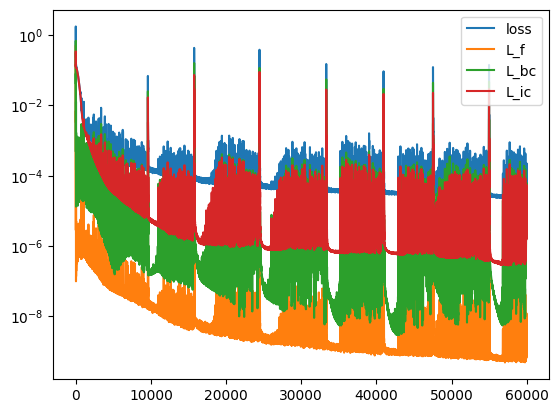

In [17]:
plt.plot(loss_pinn, label='loss')
# plt.plot(loss_regr, label='loss MSE')
plt.plot(l_physics, label='L_f')
plt.plot(l_bc, label='L_bc')
plt.plot(loss_ic, label='L_ic')
plt.legend()
plt.yscale('log');

In [28]:
model_pinn.eval();
with torch.no_grad():
    y_pred = model_pinn(torch.tensor(X_test).to(device))
    
y_pred = y_pred.to('cpu').numpy()

In [22]:
y_pred.shape

torch.Size([1790789, 2])

In [15]:
def get_density(y_pred, num_t=1000, num_x=1132):
    return (y_pred[:, 0]**2 + y_pred[:, 1]**2).reshape(num_t, num_x)
#     return (np.abs(y_pred[:, 0] + 1j*y_pred[:, 1])**2).reshape(num_t, num_x)

In [29]:
dens = get_density(y_pred, num_t=1001, num_x=y_pred.shape[0]//1001)

In [30]:
def get_num_stats(dx=np.sqrt(1/40000), dt=1/1000,x0_phase=-5):
    T = 1
    sig2 = np.sqrt(0.1)
#     dx    = np.sqrt(T / 40000) # np.sqrt(T / 1000)    100000                    # spatial separation
    x     = np.arange(-2, 2, dx)       # spatial grid points

    kx    = 0                        # mass
    sigma = sig2                      # width of initial gaussian wave-packet
    x0    = 0.0                     # center of initial gaussian wave-packet

    A = 1.0 / (sigma * np.sqrt(2*np.pi)) # normalization constant

    # Initial Wavefunction
    psi0 = np.sqrt(A) * np.exp(-(x-x0)**2 / (4.0 * (sigma**2))) * np.exp(1j * x0_phase * x )


    # Potential V(x)
    x_Vmin = 0.1         # center of V(x)

    omega = 1
    k = 1
    V = 0.5 * (x - x_Vmin)**2

    # Laplace Operator (Finite Difference)
    D2 = sparse.diags([1, -2, 1], [-1, 0, 1], shape=(x.size, x.size)) / dx**2
    # RHS of Schrodinger Equation
    hbar = h
    # hbar = 1.0545718176461565e-34
    def psi_t(t, psi):
        return -1j * (-0.5 * h  / m * D2.dot(psi) + V / hbar * psi)

#     dt = T / 1000 # T / 10000 #T / 1000  # time interval for snapshots
    t0 = 0.0    # initial time
    tf = T    # final time
    t_eval = np.linspace(t0, tf, 1000+1)#np.arange(t0, tf, dt) # np.linspace(t0, tf, len(x)**2) # np.arange(t0, tf, dt)  # recorded time shots

    # Solve the Initial Value Problem
    sol = integrate.solve_ivp(psi_t, t_span = [t0, tf], y0 = psi0, t_eval = t_eval, method="RK23")
    bmeans = []
    bstds = []
    ts = []
    for i, t in enumerate(sol.t):
        ts.append(t)
        bmeans.append(np.dot(x, dx * np.abs(sol.y[:,i])**2)) 
        bstds.append(np.dot((x - bmeans[-1]) ** 2, dx * np.abs(sol.y[:,i])**2))# Plot Wavefunctions
    return sol, bmeans, bstds

In [31]:
dx    = np.sqrt(1 / 800000) # np.sqrt(T / 1000)    100000                    # spatial separation
x_num     = np.arange(-2, 2, dx)

sol_numerical, bmeans, bstds = get_num_stats(dx=dx, x0_phase = -5)

dens_num = np.abs(sol_numerical.y.T)**2

In [32]:
ts = []
bmeans_pinn = []
bstds_pinn = []

for i, time in enumerate(t):
    ts.append(time)
    bmeans_pinn.append(np.dot(x[:, 0], delta_x * dens[i, :])) 
    bstds_pinn.append(np.dot((x[:, 0] - bmeans_pinn[-1]) ** 2, delta_x * dens[i, :]))

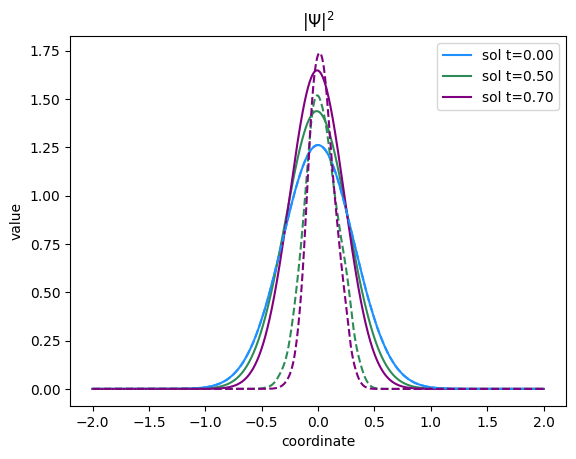

In [33]:
plt.plot(x_num, dens_num[0, :], color="dodgerblue", label="sol t={:.2f}".format(t[:, 0][0]))
plt.plot(x_num, dens_num[500, :], color="seagreen", label="sol t={:.2f}".format(t[:, 0][500]))
plt.plot(x_num, dens_num[700, :], color="purple", label="sol t={:.2f}".format(t[:, 0][700]))
plt.plot(x[:, 0], dens[0, :],'--', color="dodgerblue")
plt.plot(x[:, 0], dens[500, :], '--',  color="seagreen")
plt.plot(x[:, 0], dens[700, :],'--',  color="purple")
plt.title('$|\Psi|^2$')
plt.xlabel('coordinate')
plt.ylabel('value')
plt.legend();

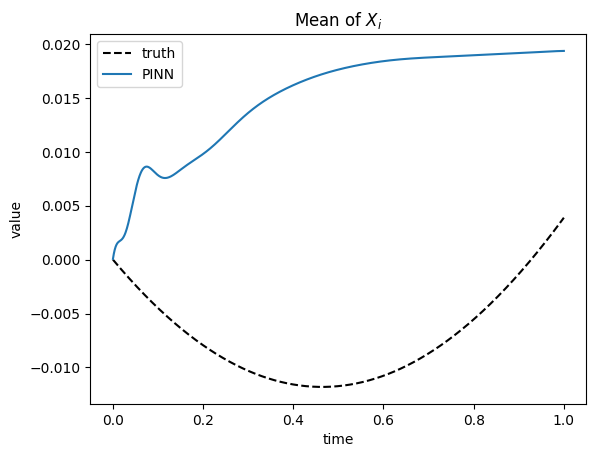

In [35]:
plt.plot(ts, bmeans, label='truth', color='black', linestyle='--',)
plt.plot(ts, bmeans_pinn, label='PINN')
plt.legend()
plt.title('Mean of $X_i$')
plt.xlabel('time')
plt.ylabel('value');

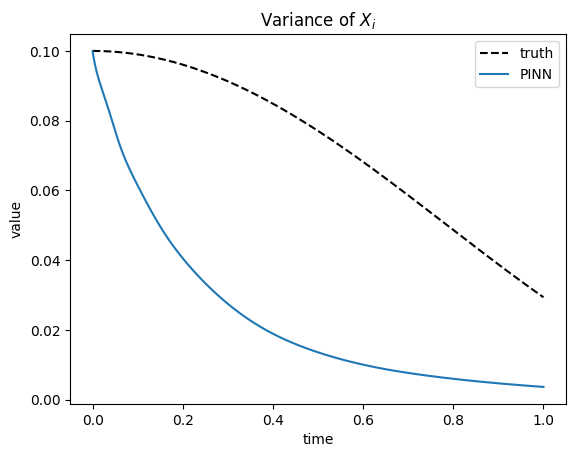

In [36]:
plt.plot(ts, bstds, label='truth', color='black', linestyle='--',)
plt.plot(ts, bstds_pinn, label='PINN')
plt.legend()
plt.title('Variance of $X_i$')
plt.xlabel('time')
plt.ylabel('value');

In [41]:
err_mean_xt = (np.linalg.norm(np.array(bmeans_pinn) - np.array(bmeans))) / (np.linalg.norm(bmeans))

err_std_xt = (np.linalg.norm(np.array(bstds_pinn) - np.array(bstds))) / (np.linalg.norm(bstds))
print('PINN 1D Err(mean(X_t)_NN, mean(X_t)_num): ', err_mean_xt)
print('PINN 1D Err(var(X_t)_NN, var(X_t)_num): ', err_std_xt)

PINN 1D Err(mean(X_t)_NN, mean(X_t)_num):  2.8089071276208086
PINN 1D Err(var(X_t)_NN, var(X_t)_num):  0.6732789516740587


/tmp/ipykernel_1141513/3605954594.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[0, :])


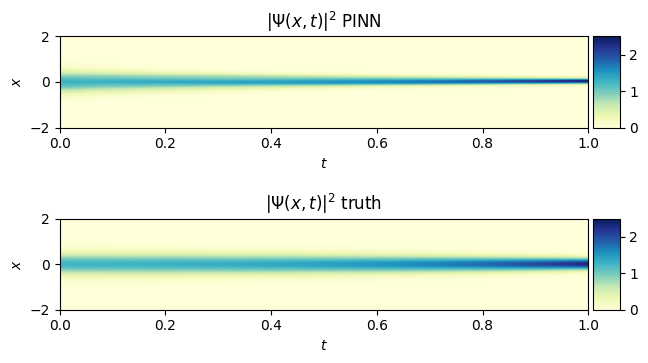

In [42]:
fig, ax = plt.subplots(1, 1) #newfig(1.0, 0.9)
fig.set_size_inches(8, 10)
# ax.axis('off')

####### Row 0: h(t,x) ##################    
gs0 = gridspec.GridSpec(2, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, hspace=1)
ax = plt.subplot(gs0[0, :])
ax1 = plt.subplot(gs0[1, :])

h_ = ax.imshow(dens.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', vmin=0., vmax=2.5)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_title('$|\Psi(x, t)|^2$ PINN', fontsize = 12);

h_ = ax1.imshow(dens_num.T, interpolation='nearest', cmap='YlGnBu', 
              extent=[lb[1], ub[1], lb[0], ub[0]], 
              origin='lower', aspect='auto', vmin=0., vmax=2.5)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h_, cax=cax)
ax1.set_xlabel('$t$')
ax1.set_ylabel('$x$')
ax1.set_title('$|\Psi(x, t)|^2$ truth', fontsize = 12);